# Deep Neural Network

In [66]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tqdm import tqdm
from IPython.display import display

from data_processing import prepare_data, split_data
from helper_functions import get_metrics

import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, Input, metrics
from tensorflow.keras.metrics import FalsePositives, TruePositives, FalseNegatives, TrueNegatives

from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix


In [71]:
# Get the data and clean it
data = prepare_data('healthcare-dataset-stroke-data.csv')

# Split the data into test, training and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

### Milestone 1: Basic model

Train on 2944 samples, validate on 982 samples
Epoch 1/30
2944/2944 [==============================] - 0s 161us/sample - loss: 0.2811 - accuracy: 0.9541 - val_loss: 0.2719 - val_accuracy: 0.9134
Epoch 2/30
2944/2944 [==============================] - 0s 37us/sample - loss: 0.1787 - accuracy: 0.9558 - val_loss: 0.2068 - val_accuracy: 0.9470
Epoch 3/30
2944/2944 [==============================] - 0s 35us/sample - loss: 0.1772 - accuracy: 0.9538 - val_loss: 0.1978 - val_accuracy: 0.9470
Epoch 4/30
2944/2944 [==============================] - 0s 34us/sample - loss: 0.1733 - accuracy: 0.9538 - val_loss: 0.1943 - val_accuracy: 0.9450
Epoch 5/30
2944/2944 [==============================] - 0s 41us/sample - loss: 0.1741 - accuracy: 0.9518 - val_loss: 0.2015 - val_accuracy: 0.9470
Epoch 6/30
2944/2944 [==============================] - 0s 45us/sample - loss: 0.1715 - accuracy: 0.9531 - val_loss: 0.1938 - val_accuracy: 0.9460
Epoch 7/30
2944/2944 [==============================] - 0s 53us/sample

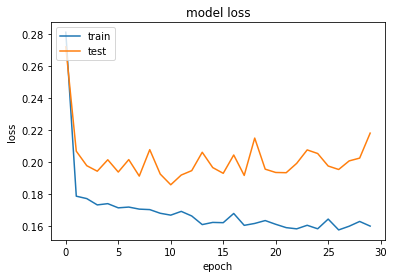

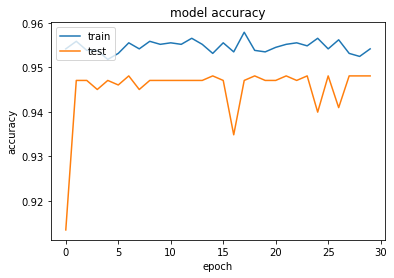

train metrics: 

accuracy: 95.8560 % 

balanced accuracy: 50.0000 %
sensitivity: 0.0
specificity: 1.0 

confusion matrix: 
[[2822    0]
 [ 122    0]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

test metrics: 

accuracy: 94.8065 % 

balanced accuracy: 50.0000 %
sensitivity: 0.0
specificity: 1.0 

confusion matrix: 
[[931   0]
 [ 51   0]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



In [73]:
def train_and_predict(model, training_data, training_labels, testing_data, testing_labels, epochs=5):
    """
    This function trains a given neural network model based on training data and training labels. It then predicts classes on
    training and testing data. It is possible to adjust for how many epochs the model is trained
    """
    # Compile the layers of the model defined earlier. Use the binary cross entropy function as the loss function as we only
    # have 2 output classes and use accuracy as the metric
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model for a number of epochs
    history = model.fit(training_data, training_labels, epochs=epochs, validation_data=(testing_data, testing_labels))

    # Predict the classes of the training data
    predictions_train = model.predict(training_data) >= 0.5
    
    # Predict the classes on the testing data
    predictions_test = model.predict(testing_data) >= 0.5
    
    # Plot the accuracy over epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

    return predictions_train, predictions_test

# Get the amount of input features for the nodes in the first layer
input_shape = np.shape(train_data)[1]

# Create the model
model = models.Sequential()

# First layer with input nodes equal to features
model.add(Input(shape=(input_shape)))

# One hidden layer with 25 nodes
model.add(layers.Dense(25, activation='relu'))

# Output layer with 1 node (only 1 output class, 0 or 1 for stroke) and sigmoid activation function
model.add(layers.Dense(1, 'sigmoid'))

# Train and predict
predictions_train, predictions_test = train_and_predict(model, train_data, 
                                                        train_labels, test_data, test_labels,
                                                        epochs=30)

# Print metrics
print('train metrics: \n')
accuracy_train, balanced_accuracy_train = get_metrics(train_labels, predictions_train, verbose=True)

print('test metrics: \n')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)



### Milestone 2: Actual model
##### Additions:
1. Weighted loss to increase sensitivity to stroke cases.
2. Added more metrics

  ...
    to  
  ['...']
  ...
    to  
  ['...']


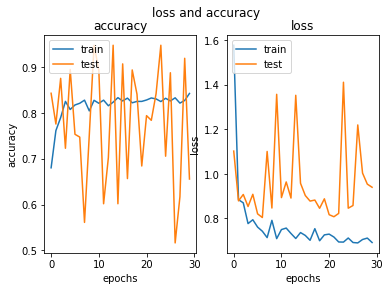

train metrics: 

accuracy: 66.1345 % 

balanced accuracy: 75.6692 %
sensitivity: 0.860655737704918
specificity: 0.6527285613040397 

confusion matrix: 
[[1842  980]
 [  17  105]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

test metrics: 

accuracy: 65.5804 % 

balanced accuracy: 73.5073 %
sensitivity: 0.8235294117647058
specificity: 0.6466165413533834 

confusion matrix: 
[[602 329]
 [  9  42]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



In [55]:
def train_and_predict(model, training_data, training_labels, 
                      testing_data, testing_labels, epochs=5, 
                      loss_weight=10, verbose=0, plot=True):
    """
    This function trains a given neural network model based on training data and training labels. It then predicts classes on
    training and testing data. It is possible to adjust for how many epochs the model is trained.
    
    input:
    
    model:        model architecture defined before calling this function
    loss_weight:  errors on the stroke class should be weighted heavier then the non-stroke class. 
                  The value defines how much more this loss is weighted. loss_weight=10 means a ratio of 1 to 10.
                  For some reason
    verbose:      0: no text per epoch
                  1: text for each epoch
    plot:         True: show accuracy and loss over epochs in figure
                  False: no plot
                  
    output: 
    
    predictions_train: vector of training predictions
    predictions_test:  vector of test predictions
    history:           dict containing measures over epochs, including loss, accuracy, TP, FP, TN, FN, for train and test data.
                       print history.history for all measures and their keys.
    
    """
    # extra metrics to store after each epoch, useful for keeping track during epochs:
    TP = TruePositives()
    FP = FalsePositives()
    TN = TrueNegatives()
    FN = FalseNegatives()
    
    # Compile the layers of the model defined earlier. Use the binary cross entropy function as the loss function as we only
    # have 2 output classes and use accuracy as the metric
    model.compile(loss='binary_crossentropy', metrics=['accuracy', TP, FP, TN, FN])
    
    # Train the model for a number of epochs
    history = model.fit(training_data, training_labels, epochs=epochs, 
                        validation_data=(testing_data, testing_labels),
                        class_weight=[{0: 1., 1: loss_weight}],
                        verbose=verbose
                       )

    # Predict the classes of the training data
    predictions_train = model.predict(training_data) >= 0.5
    
    # Predict the classes on the testing data
    predictions_test = model.predict(testing_data) >= 0.5
    
    # Plot the loss and accuracy over epochs.
    if plot:
        fig, axs = plt.subplots(1, 2)
        fig.suptitle('loss and accuracy')
    
        axs[0].plot(history.history['accuracy'])
        axs[0].plot(history.history['val_accuracy'])
        axs[0].legend(['train', 'test'], loc='upper left')
        axs[0].set_title('accuracy')
        axs[0].set_ylabel('accuracy')
        axs[0].set_xlabel('epochs')


        # Plot the loss over epochs
        axs[1].plot(history.history['loss'])
        axs[1].plot(history.history['val_loss'])
        axs[1].set_title('loss')
        axs[1].set_xlabel('epochs')
        axs[1].set_ylabel('loss')
        axs[1].legend(['train', 'test'], loc='upper left')

    
    plt.show()

    return predictions_train, predictions_test, history

# Get the amount of input features for the nodes in the first layer
input_shape = np.shape(train_data)[1]

# Create the model
model = models.Sequential()

# First layer with input nodes equal to features
model.add(Input(shape=(input_shape)))

# One hidden layer with 25 nodes
model.add(layers.Dense(25, activation='relu'))

# Output layer with 1 node (only 1 output class, 0 or 1 for stroke) and sigmoid activation function
model.add(layers.Dense(1, 'sigmoid'))

# Train and predict
predictions_train, predictions_test, history = train_and_predict(model, train_data, 
                                                        train_labels, test_data, test_labels,
                                                        epochs=30, verbose=0)

# Print metrics
print('train metrics: \n')
accuracy_train, balanced_accuracy_train = get_metrics(train_labels, predictions_train, verbose=True)

print('test metrics: \n')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)



  0%|          | 0/15 [00:00<?, ?it/s]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


  7%|▋         | 1/15 [00:17<04:04, 17.47s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 13%|█▎        | 2/15 [00:35<03:54, 18.00s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 20%|██        | 3/15 [00:54<03:40, 18.37s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 27%|██▋       | 4/15 [01:13<03:26, 18.74s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 33%|███▎      | 5/15 [01:33<03:08, 18.86s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 40%|████      | 6/15 [01:52<02:51, 19.09s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 47%|████▋     | 7/15 [02:12<02:34, 19.29s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 53%|█████▎    | 8/15 [02:30<02:11, 18.85s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 60%|██████    | 9/15 [02:47<01:50, 18.42s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 67%|██████▋   | 10/15 [03:05<01:31, 18.38s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 73%|███████▎  | 11/15 [03:24<01:13, 18.31s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 80%|████████  | 12/15 [03:42<00:55, 18.48s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 87%|████████▋ | 13/15 [04:02<00:37, 18.74s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 93%|█████████▎| 14/15 [04:21<00:18, 18.83s/it]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


100%|██████████| 15/15 [04:40<00:00, 18.68s/it]


ValueError: x and y must have same first dimension, but have shapes (29,) and (15,)

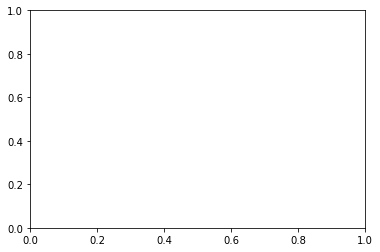

In [61]:
# Test different loss weights and plot accuracy and sensitivity (average over 3 runs)

# For some reason 

accuracies_test = []
sensitivities_test = []
for i in tqdm(range(1, 30, 2)):
    # Train and predict
    accuracy_sum = 0
    sensitivity_sum = 0
    for i in range(3):
        predictions_train, predictions_test, history = train_and_predict(model, train_data, 
                                                                train_labels, test_data, test_labels,
                                                                epochs=30, verbose=0, plot=False,
                                                                loss_weight=i)
        # metrics
        accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=False)
        conmat = confusion_matrix(test_labels, predictions_test)
        sensitivity = conmat[1,1] / sum(conmat[1,:])
        
        accuracy_sum = accuracy_sum + accuracy_test
        sensitivity_sum = sensitivity_sum + sensitivity
    
    accuracies_test.append(accuracy_sum / 3)
    sensitivities_test.append(sensitivity_sum / 3)

plt.plot(range(1,30,2), accuracies_test)
plt.plot(range(1,30,2), sensitivities_test)
plt.ylim(0, 1)
plt.ylabel('accuracy, sensitivity')
plt.legend(['accuracy', 'sensitivity'])
plt.show()
    


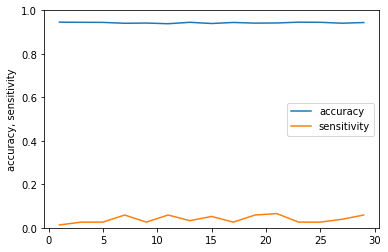

In [64]:
plt.plot(range(1,30,2), accuracies_test)
plt.plot(range(1,30,2), sensitivities_test)
plt.ylim(0, 1)
plt.ylabel('accuracy, sensitivity')
plt.legend(['accuracy', 'sensitivity'])
plt.show()
    